In [87]:
from scipy.io import loadmat
import numpy as np
import os
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt

In [121]:
# Indexer
class Subjects:
    class Sessions:
        class Runs:

            def __init__(self, paths) -> None:
                self.paths = sorted(paths, key= lambda x: int(x.split('_')[-1][3]))

            def __getitem__(self, run_idx):
                return self.load_data(self.paths[run_idx])
            
            def load_data(self, path):
                mat_contents = loadmat(path, struct_as_record=False, squeeze_me=True)
                return mat_contents["p"].__dict__

        def __init__(self, path) -> None:
            self.base_path = os.path.join(path, "runs")
            self.sess_paths = sorted(os.listdir(self.base_path), key= lambda x: int(x.split('_')[2][1]))
            self.sess_paths = [os.path.join(self.base_path, path) for path in self.sess_paths]
            self.sess_paths = [self.sess_paths[i:i+6] for i in range(0, len(self.sess_paths), 6)]

        def __getitem__(self, sess_idx):
            return self.Runs(self.sess_paths[sess_idx])

    def __init__(self, path) -> None:
        self.path = path
        self.subj_paths = sorted(os.listdir(path), key=lambda x: int(x.split('j')[1]))

    def __getitem__(self, sub_idx):
        return self.Sessions(os.path.join(self.path, self.subj_paths[sub_idx]))

# Refresher
def np_refresh(np_array): return np.array(np_array.tolist()).astype("float")

In [122]:
# Set in stone
PATH_DS = '../axej_eeg'
EXP_ORI = [159, 123, 87, 51, 15]
SUBS = 13
SESS = 4
RUNS = 6

subj = Subjects(PATH_DS)

# Index combinations at 3 levels with ittertools
data_idx = list(itertools.product(range(SUBS), range(SESS), range(RUNS)))

In [123]:
# Expectation
# pcat.tr_exp = pcat.trlabel(pcat.prior == 1);
# pcat.tr_un = pcat.trlabel(pcat.prior == 3);
# pcat.tr_neu = pcat.trlabel(pcat.prior == 2);

# Attention = attCue
# pcat.tr_foc = pcat.trlabel(pcat.attcue == 1); = attCue
# pcat.tr_div = pcat.trlabel(pcat.attcue == 2); = attCue
# div -> -1, for -> 1

# Coherence = tgCoh
# pcat.tr_lo = pcat.trlabel(pcat.moco == 1); = tgCoh
# pcat.tr_hi = pcat.trlabel(pcat.moco == 2); = tgCoh
# low -> -1, high -> 1

# Observation = response_angle

# Target = stimDirREAL
# Coherece oriantation = EXP_ORI[p.expOri]
# Coherence strength = tgCoh
# Attention state = attCue
# bias = np.ones

In [124]:
shape = (SESS, RUNS - 1)

jx = np.ndarray(shape=shape, dtype=object)
jy = np.ndarray(shape=shape, dtype=object)
sti_dir = np.ndarray(shape=shape, dtype=object)
ori_dir = np.ndarray(shape=shape, dtype=object)
ori_st = np.ndarray(shape=shape, dtype=object)
att_st = np.ndarray(shape=shape, dtype=object)

subs = 5
for sess, runs in itertools.product(range(SESS), range(RUNS)):
    if runs == 5: continue
    data = subj[subs][sess][runs]
    jx[sess, runs] = data['joyx']
    jy[sess, runs] = data['joyy']
    sti_dir[sess, runs] = data['stimDirREAL']
    ori_dir[sess, runs] = EXP_ORI[data['expOri'] - 1]
    ori_st[sess, runs] = data['tgCoh']
    att_st[sess, runs] = data['attCue']

jx = np_refresh(jx)
jy = np_refresh(jy)
sti_dir = np_refresh(sti_dir)
ori_dir = np_refresh(ori_dir)
ori_st = np_refresh(ori_st)
att_st = np_refresh(att_st)

# Repeat ori for each trial
ori_dir = np.expand_dims(ori_dir, axis=2)
ori_dir = np.repeat(ori_dir, 120, axis=2)

jx.shape, jy.shape

((4, 5, 120, 500), (4, 5, 120, 500))

In [125]:
sti_dir.shape, ori_dir.shape, ori_st.shape, att_st.shape

((4, 5, 120), (4, 5, 120), (4, 5, 120), (4, 5, 120))

In [126]:
def make_responses(jx, jy):
    dist_from_cent = np.sqrt(jx ** 2 + jy ** 2)
    dist_from_cent[np.isnan(dist_from_cent)] = 0
    max_idx = np.argmax(dist_from_cent, axis=3)

    max_x = jx[np.arange(4)[:, np.newaxis, np.newaxis], np.arange(5)[:, np.newaxis], np.arange(120), max_idx]
    max_y = jy[np.arange(4)[:, np.newaxis, np.newaxis], np.arange(5)[:, np.newaxis], np.arange(120), max_idx]

    resp_angle = np.arctan2(max_y, max_x)
    resp_angle = np.rad2deg(resp_angle)

    return resp_angle, max_idx

In [127]:
resp_angle, resp_idx = make_responses(jx, jy)
resp_angle.shape, resp_idx.shape

((4, 5, 120), (4, 5, 120))

In [130]:
# replace all 2 with -1 for input_att_st
att_st[att_st == 2] = -1.0

ori_st[ori_st == 1] = -1.0
ori_st[ori_st == 2] = 1.0

In [131]:
resp_angle.shape, sti_dir.shape, ori_dir.shape, ori_st.shape, att_st.shape

((4, 5, 120), (4, 5, 120), (4, 5, 120), (4, 5, 120), (4, 5, 120))

In [132]:
import pandas as pd

df = pd.DataFrame({
    'resp_angle': resp_angle.flatten()/180,
    'sti_dir': sti_dir.flatten()/ 180,
    'ori_dir': ori_dir.flatten()/ 180,
    'ori_st': ori_st.flatten(),
    'att_st': att_st.flatten(),
})

In [133]:
# correct = resp_angle / sti_dir if resp_angle < sti_dir or else sti_dir / resp_angle
df["err"] = df["resp_angle"] - df["sti_dir"]
# make all errs positive
df["err"] = df["err"].abs()

In [135]:
df

,resp_angle,sti_dir,ori_dir,ori_st,att_st,err
0,0.342095,0.083333,0.883333,-1.0,-1.0,0.258761
1,0.840422,0.883333,0.883333,-1.0,-1.0,0.042912
2,0.176434,0.883333,0.883333,1.0,1.0,0.706899
3,0.610951,0.683333,0.883333,1.0,-1.0,0.072382
4,0.168584,0.883333,0.883333,-1.0,1.0,0.714749
...,...,...,...,...,...,...
2395,0.150625,0.083333,0.083333,-1.0,1.0,0.067291
2396,0.152134,0.083333,0.083333,1.0,-1.0,0.068801
2397,0.146563,0.083333,0.083333,1.0,1.0,0.063230
2398,0.156618,0.083333,0.083333,-1.0,-1.0,0.073285


<Axes: >

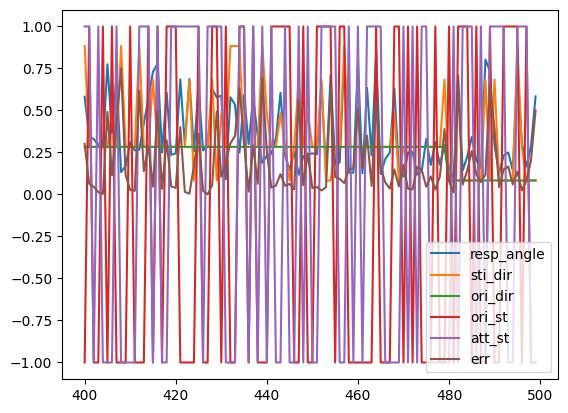

In [144]:
idx = 400
df[idx:idx+100].plot()

In [138]:
# group by attention state and average error

df.groupby("att_st").mean()["err"]

att_st
-1.0    0.188287
 1.0    0.183581
Name: err, dtype: float64

In [140]:
[ x * 180 for x in [0.188287, 0.183581]]

[33.89166, 33.044579999999996]

# Model

In [10]:
from scipy import io
from pathlib import Path

import numpy as np
rng = np.random.default_rng()

import jax.numpy as jnp
import jax.random as jr

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from dynamax.hidden_markov_model import LinearRegressionHMM
from dynamax.utils.plotting import gradient_cmap

I0000 00:00:1699036117.756092   27174 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [11]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [12]:
def plot_emissions_and_states(emissions, most_likely_states, posterior, cmap, colors):
    
    plot_slice = (0, emissions.shape[0])
    emission_dim = emissions.shape[-1]
    time_bins = emissions.shape[0]
    state_probability_spread = posterior.smoothed_probs.T
    lim = 1.1 * max(abs(emissions).max(), 1)
    # lim = 1

    plt.figure(figsize=(8, 6))
    plt.suptitle("Emissions and Inferred States", y=1.01)

    # Plot number 1
    plt.subplot(211)

    im = plt.imshow(most_likely_states[None, :],
        aspect="auto",
        cmap=cmap,
        vmin=0,
        vmax=len(colors)-1,
        extent=(0, time_bins, 0, (emission_dim)*lim)
    )

    values = np.unique(most_likely_states.ravel())
    colors = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label="State {l}".format(l=values[i]) ) for i in range(len(values)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Most Likely Z")

    # emissions line
    for d in range(emission_dim):
        plt.plot(emissions[:,d] + lim * d, '-k')

    plt.xlim(plot_slice)
    plt.yticks([159, 123, 87, 51, 15])


    # Plot number 2
    plt.subplot(212)
    plt.imshow(state_probability_spread, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
    plt.xlim(plot_slice)
    plt.ylabel("$z_{\\mathrm{inferred}}$")
    plt.yticks(ticks=range(state_probability_spread.shape[0]), labels=range(state_probability_spread.shape[0]))
    plt.xlabel("time")

    plt.show()

def plot_lps(lps): 
    plt.figure(figsize=(6, 3))
    # true_lp = true_arhmm.marginal_log_prob(true_params, emissions, inputs=inputs)
    plt.plot(lps, label="EM")
    # plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
    plt.xlabel("EM Iteration")
    plt.ylabel("Log Probability")
    plt.legend(loc="lower right")
    plt.show()

def plot_validation(cross_valids, show_var = True, max_states = 7):
    avg_val_lls = cross_valids.mean(axis=1)
    plt.plot(range(2, max_states), avg_val_lls, '-ko')
    if show_var:
        for k, per_fold_val_lls in zip(range(2, max_states), cross_valids):
            plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
    plt.xticks(range(2, max_states))
    plt.xlabel("num states ($K$)")
    plt.ylabel("avg. validation log prob.")
    plt.show()

In [13]:
emissions = resp_angle.reshape(-1, 120)

emissions.shape

(20, 120)

In [14]:
sti_dir.shape, ori_dir.shape, ori_st.shape, att_st.shape, 

((4, 5, 120), (4, 5, 120), (4, 5, 120), (4, 5, 120))

In [15]:
inp_sti_dir = np.expand_dims(sti_dir.reshape(-1, 120), axis=2).astype(np.float32)
inp_ori_dir = np.expand_dims(ori_dir.reshape(-1, 120), axis=2).astype(np.float32)
inp_ori_st = np.expand_dims(ori_st.reshape(-1, 120), axis=2).astype(np.float32)
inp_att_st = np.expand_dims(att_st.reshape(-1, 120), axis=2).astype(np.float32)

In [16]:
inp_sti_dir.shape, inp_ori_dir.shape, inp_ori_st.shape, inp_att_st.shape

((20, 120, 1), (20, 120, 1), (20, 120, 1), (20, 120, 1))

In [17]:
# replace all 2 with -1 for input_att_st
inp_att_st[inp_att_st == 2] = -1.0

inp_ori_st[inp_ori_st == 1] = -1.0
inp_ori_st[inp_ori_st == 2] = 1.0

In [18]:
cursor = np.expand_dims(emissions, axis=2)
exp_bias = np.zeros((20, 120, 1))

train_emissions = cursor
train_inputs = np.concatenate((inp_sti_dir, inp_ori_dir, inp_ori_st, inp_att_st, exp_bias), axis=2)

train_emissions.shape, train_inputs.shape

((20, 120, 1), (20, 120, 5))

In [19]:
def train_arhmm(num_states, emission_dim, input_dim, train_emissions, train_inputs):
    # Initialize with K-Means
    lrhmm = LinearRegressionHMM(num_states, input_dim, emission_dim)
    params, props = lrhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=train_emissions)

    # Fit with EM
    fitted_params, lps = lrhmm.fit_em(params, props, train_emissions, inputs=train_inputs, num_iters=500, verbose=False)

    return lrhmm, fitted_params, lps

In [ ]:
all_models, all_params, all_lps = [], [], []

# num_states = 4
input_dim = 5
emission_dim = 1

min_state = 2
max_state = 10

for num_states in range(min_state, max_state):
    print(f'Training: {num_states} states')
    arhmm, fitted_params, lps = train_arhmm(num_states, emission_dim, input_dim, train_emissions, train_inputs)
    all_models.append(arhmm)
    all_params.append(fitted_params)
    all_lps.append(lps)

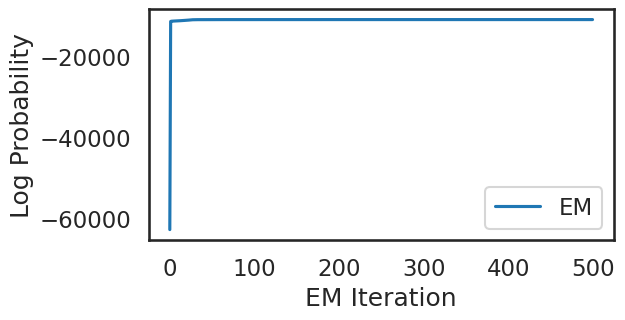

In [21]:
check_state = 5
plot_lps(all_lps[check_state-2])

In [22]:
def cross_validate(all_models, all_params, emissions, inputs):
    cross_valids = []

    for model_idx in range(len(all_models)):
        print(f'Cross Validating: {model_idx} model')
        state_log_probs = []
        for validation_idx in range(len(emissions)):
            log_prob = all_models[model_idx].marginal_log_prob(all_params[model_idx], emissions[validation_idx], inputs=inputs[validation_idx])
            state_log_probs.append(float(log_prob))
        cross_valids.append(state_log_probs)

    return np.array(cross_valids)

Cross Validating: 0 model
Cross Validating: 1 model
Cross Validating: 2 model
Cross Validating: 3 model
Cross Validating: 4 model
Cross Validating: 5 model
Cross Validating: 6 model
Cross Validating: 7 model


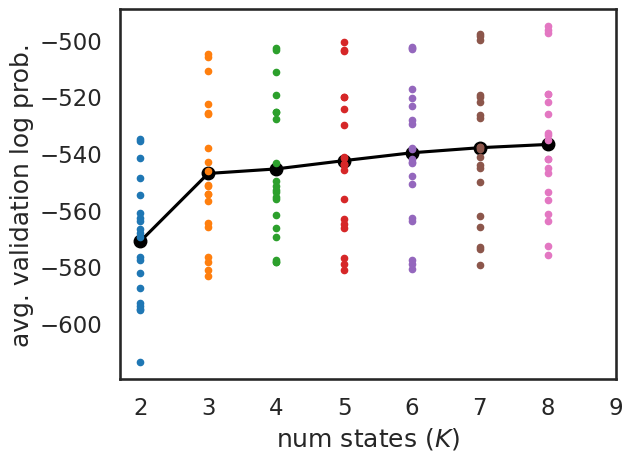

In [23]:
cross_train = cross_validate(all_models, all_params, train_emissions, train_inputs)
plot_validation(cross_valids=cross_train, show_var=True, max_states=max_state)

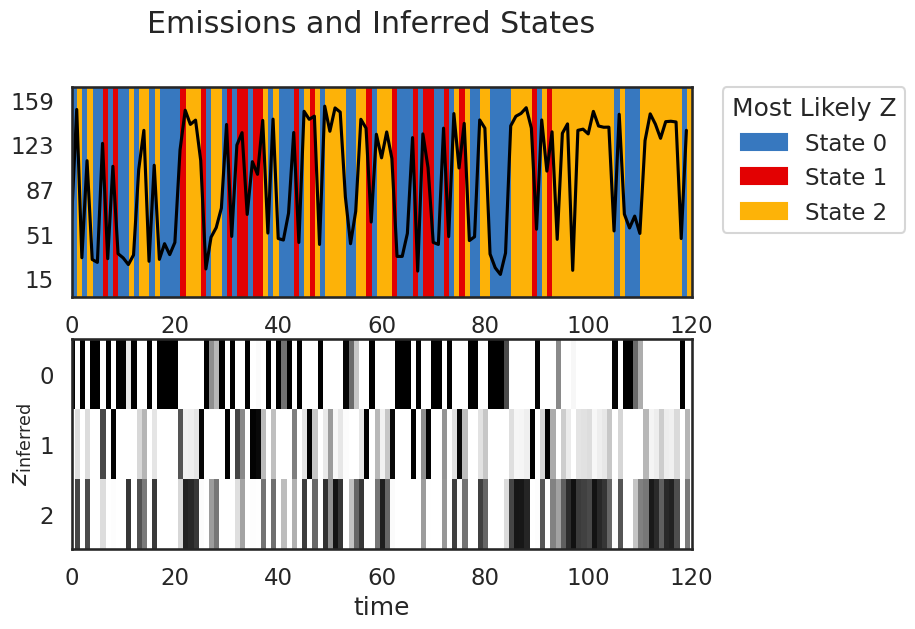

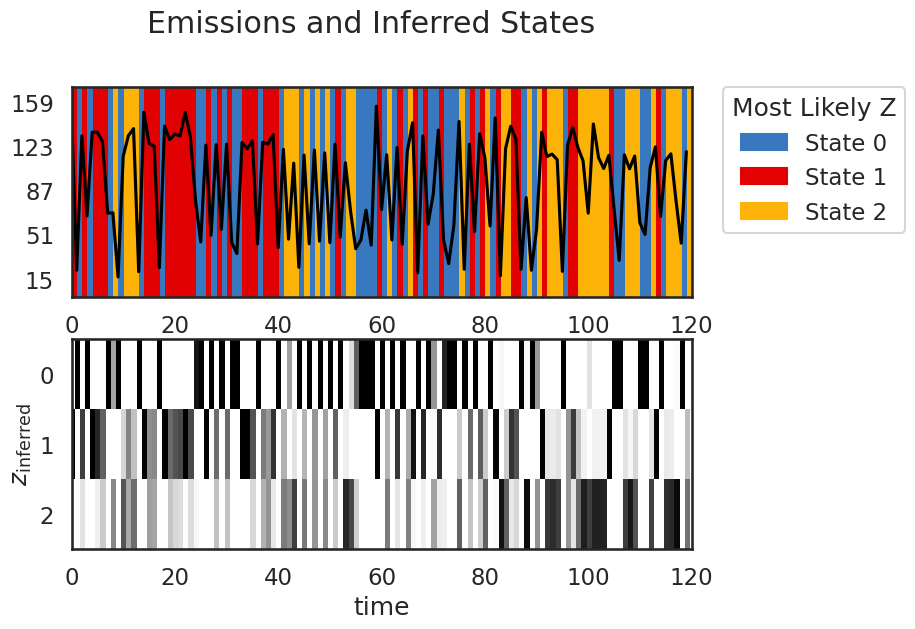

In [24]:
def inspect_sample(model_idx, em_idx):
    most_likely_states = all_models[model_idx].most_likely_states(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    posterior = all_models[model_idx].smoother(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    plot_emissions_and_states(train_emissions[em_idx], most_likely_states, posterior, cmap, colors)

for i in range(2):
    inspect_sample(3-2, i)

| state 1 | bias 45.32974624633789 | covs 161.38107299804688 | wts [[-0.0022115972824394703, 0.02175016514956951, 0.8720535039901733, 1.0182875394821167, 0.0]] |
--------------------------------------------------
| state 2 | bias 124.23986053466797 | covs 172.61830139160156 | wts [[-0.00819458905607462, 0.03595135360956192, 0.8346760869026184, -0.556847870349884, 0.0]] |
--------------------------------------------------
| state 3 | bias 10.80051326751709 | covs 104.37586975097656 | wts [[0.7890653610229492, 0.036685552448034286, -0.7461520433425903, -0.5432309508323669, 0.0]] |
--------------------------------------------------


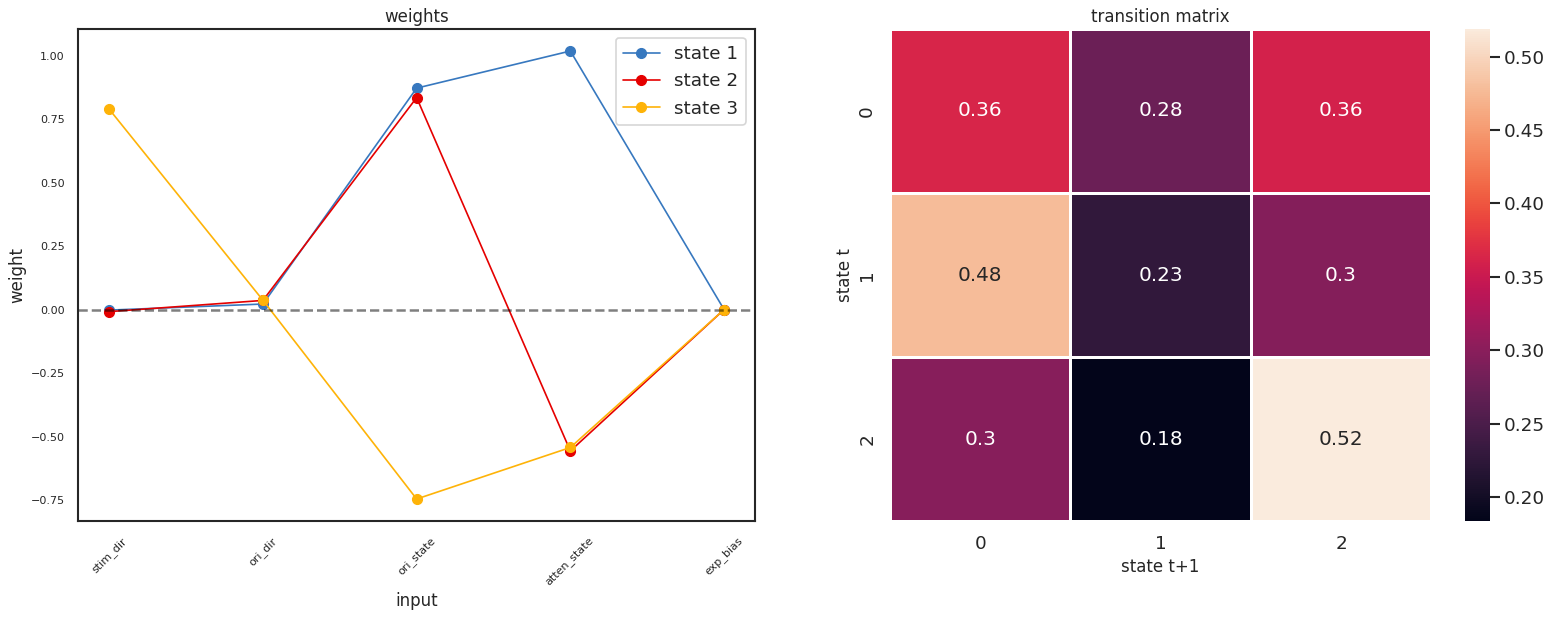

In [33]:
check_state = 3

fourth = all_models[check_state - 2]
p_fourth = all_params[check_state - 2]

curr_states = check_state

# Plot MLE parameters:
fig = plt.figure(figsize=(12*2, 4*2), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = colors
for k in range(curr_states):
    plt.plot(range(input_dim), p_fourth.emissions.weights[k][0], marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))
plt.yticks(fontsize=10)
plt.ylabel("weight", fontsize=15)
plt.xlabel("input", fontsize=15)
plt.xticks([0, 1, 2, 3, 4], ["stim_dir", "ori_dir", "ori_state", "atten_state", "exp_bias"], fontsize=10, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("weights", fontsize = 15)

plt.subplot(1, 2, 2)
gen_trans_mat = p_fourth.transitions.transition_matrix
sns.heatmap(gen_trans_mat, annot=True, linewidths=1, linecolor='white', )
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("transition matrix", fontsize = 15)

bias = p_fourth.emissions.biases.reshape(-1).tolist()
covs = p_fourth.emissions.covs.reshape(-1).tolist()
wts = p_fourth.emissions.weights.tolist()

for i in range(check_state):
    print("| state", i+1, "| bias", bias[i], "| covs", covs[i], "| wts", wts[i], "|")
    print("-"*50)

In [27]:
# inp_sti_dir, inp_ori_dir, inp_ori_st, inp_att_st, exp_bias

# stim_dir
# ori_dir
# ori_state
# atten_state
# exp_bias